## **Install conda and rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-05-26 14:34:16--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   141MB/s    in 0.6s    

2021-05-26 14:34:17 (141 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

## **Load bioactivity data**

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/smile_activity_data_short.csv')
df

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,SMILES
0,85807145,Active,87.0,C[C@@H]1CN(C(=O)C2=C(C(=CC=C2)NS(=O)(=O)C3=C(O...
1,85791767,Active,57.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NC(=O)CC3=CN(C4=...
2,85799112,Active,68.0,C[C@H]1CN(C(=O)C2=C(C(=CC=C2)NC(=O)NC3=CC=C(C=...
3,131418956,Active,22.0,C[C@@H]1CN(S(=O)(=O)C2=C(C=C(C=C2)C#CC3=CC=CC=...
4,131443791,Active,27.0,C1CC1CNC(=O)C[C@@H]2C[C@@H]3[C@H]([C@@H](O2)CO...
...,...,...,...,...
11127,131442737,Inactive,1.0,CS(=O)(=O)NC1=CC2=C(C=C1)O[C@@H]3[C@H]2C[C@H](...
11128,85795573,Inactive,5.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NS(=O)(=O)C3=CC=...
11129,26726705,Inactive,2.0,C1COCCN1CCCN2C(NC3=CC=CC=C3C2=O)C4=CC=CC=C4
11130,49723061,Inactive,-1.0,C1COC2=CC=CC=C2N1C(=O)CCC(=O)NC3=CC=CC=C3Br


## **Clean Bioactivity data**

In [ ]:
df_no_smiles = df.drop(columns='SMILES')

In [ ]:
smiles = []

for i in df.SMILES.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,canonical_smiles
0,85807145,Active,87.0,C[C@@H]1CN(C(=O)C2=C(C(=CC=C2)NS(=O)(=O)C3=C(O...
1,85791767,Active,57.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NC(=O)CC3=CN(C4=...
2,85799112,Active,68.0,C[C@H]1CN(C(=O)C2=C(C(=CC=C2)NC(=O)NC3=CC=C(C=...
3,131418956,Active,22.0,C[C@@H]1CN(S(=O)(=O)C2=C(C=C(C=C2)C#CC3=CC=CC=...
4,131443791,Active,27.0,C1CC1CNC(=O)C[C@@H]2C[C@@H]3[C@H]([C@@H](O2)CO...
...,...,...,...,...
11127,131442737,Inactive,1.0,CS(=O)(=O)NC1=CC2=C(C=C1)O[C@@H]3[C@H]2C[C@H](...
11128,85795573,Inactive,5.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NS(=O)(=O)C3=CC=...
11129,26726705,Inactive,2.0,C1COCCN1CCCN2C(NC3=CC=CC=C3C2=O)C4=CC=CC=C4
11130,49723061,Inactive,-1.0,C1COC2=CC=CC=C2N1C(=O)CCC(=O)NC3=CC=CC=C3Br


## **Calculate Lipinski descriptors**

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def get_moldata(smiles, verbose=False):
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)

    return moldata


def clean_Nones(moldata, df):
    indices_to_drop = []
    new_moldata = []
    index = 0
    for i in moldata:
        if type(i) == type(moldata[0]):
            new_moldata.append(i)
        else:
            indices_to_drop.append(index)
        index += 1

    new_df = df.copy()
    new_df = new_df.drop(index=list(indices_to_drop), inplace=False)
    new_df = new_df.reset_index(drop=True, inplace=False)

    print(f"Dropped {len(indices_to_drop)} rows")
    print(f"Found {len(new_moldata)} useful moldata")

    return new_moldata, new_df


def lipinski(moldata, verbose=False):
       
    baseData= np.arange(1,1)
    i=0  
    counter = 0
    for mol in moldata:
        counter += 1
        if counter%100 == 0:
          print(f"{counter} out of {len(moldata)}")
        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
          
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1    

        
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
moldata = get_moldata(df_clean_smiles.canonical_smiles)
(cleaned_moldata, new_df_clean_smiles) = clean_Nones(moldata,df_clean_smiles)
df_lipinski = lipinski(cleaned_moldata)

Dropped 0 rows
Found 11132 useful moldata
100 out of 11132
200 out of 11132
300 out of 11132
400 out of 11132
500 out of 11132
600 out of 11132
700 out of 11132
800 out of 11132
900 out of 11132
1000 out of 11132
1100 out of 11132
1200 out of 11132
1300 out of 11132
1400 out of 11132
1500 out of 11132
1600 out of 11132
1700 out of 11132
1800 out of 11132
1900 out of 11132
2000 out of 11132
2100 out of 11132
2200 out of 11132
2300 out of 11132
2400 out of 11132
2500 out of 11132
2600 out of 11132
2700 out of 11132
2800 out of 11132
2900 out of 11132
3000 out of 11132
3100 out of 11132
3200 out of 11132
3300 out of 11132
3400 out of 11132
3500 out of 11132
3600 out of 11132
3700 out of 11132
3800 out of 11132
3900 out of 11132
4000 out of 11132
4100 out of 11132
4200 out of 11132
4300 out of 11132
4400 out of 11132
4500 out of 11132
4600 out of 11132
4700 out of 11132
4800 out of 11132
4900 out of 11132
5000 out of 11132
5100 out of 11132
5200 out of 11132
5300 out of 11132
5400 out of 1

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [ ]:
 df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,551.666,2.36214,3.0,8.0
1,636.746,4.03940,2.0,7.0
2,602.629,5.84060,3.0,5.0
3,514.648,2.29980,2.0,6.0
4,469.513,3.38040,4.0,5.0
...,...,...,...,...
11127,480.970,2.41240,3.0,6.0
11128,572.709,3.93290,3.0,7.0
11129,351.450,2.97540,1.0,4.0
11130,389.249,3.59340,1.0,3.0


In [ ]:
new_df_clean_smiles

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,canonical_smiles
0,85807145,Active,87.0,C[C@@H]1CN(C(=O)C2=C(C(=CC=C2)NS(=O)(=O)C3=C(O...
1,85791767,Active,57.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NC(=O)CC3=CN(C4=...
2,85799112,Active,68.0,C[C@H]1CN(C(=O)C2=C(C(=CC=C2)NC(=O)NC3=CC=C(C=...
3,131418956,Active,22.0,C[C@@H]1CN(S(=O)(=O)C2=C(C=C(C=C2)C#CC3=CC=CC=...
4,131443791,Active,27.0,C1CC1CNC(=O)C[C@@H]2C[C@@H]3[C@H]([C@@H](O2)CO...
...,...,...,...,...
11127,131442737,Inactive,1.0,CS(=O)(=O)NC1=CC2=C(C=C1)O[C@@H]3[C@H]2C[C@H](...
11128,85795573,Inactive,5.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NS(=O)(=O)C3=CC=...
11129,26726705,Inactive,2.0,C1COCCN1CCCN2C(NC3=CC=CC=C3C2=O)C4=CC=CC=C4
11130,49723061,Inactive,-1.0,C1COC2=CC=CC=C2N1C(=O)CCC(=O)NC3=CC=CC=C3Br


Now, let's combine the 2 DataFrame

In [ ]:
df_combined = pd.concat([new_df_clean_smiles,df_lipinski], axis=1)

In [ ]:
new_df_clean_smiles.shape, df_lipinski.shape

((11132, 4), (11132, 4))

In [ ]:
df_combined

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,85807145,Active,87.0,C[C@@H]1CN(C(=O)C2=C(C(=CC=C2)NS(=O)(=O)C3=C(O...,551.666,2.36214,3.0,8.0
1,85791767,Active,57.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NC(=O)CC3=CN(C4=...,636.746,4.03940,2.0,7.0
2,85799112,Active,68.0,C[C@H]1CN(C(=O)C2=C(C(=CC=C2)NC(=O)NC3=CC=C(C=...,602.629,5.84060,3.0,5.0
3,131418956,Active,22.0,C[C@@H]1CN(S(=O)(=O)C2=C(C=C(C=C2)C#CC3=CC=CC=...,514.648,2.29980,2.0,6.0
4,131443791,Active,27.0,C1CC1CNC(=O)C[C@@H]2C[C@@H]3[C@H]([C@@H](O2)CO...,469.513,3.38040,4.0,5.0
...,...,...,...,...,...,...,...,...
11127,131442737,Inactive,1.0,CS(=O)(=O)NC1=CC2=C(C=C1)O[C@@H]3[C@H]2C[C@H](...,480.970,2.41240,3.0,6.0
11128,85795573,Inactive,5.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NS(=O)(=O)C3=CC=...,572.709,3.93290,3.0,7.0
11129,26726705,Inactive,2.0,C1COCCN1CCCN2C(NC3=CC=CC=C3C2=O)C4=CC=CC=C4,351.450,2.97540,1.0,4.0
11130,49723061,Inactive,-1.0,C1COC2=CC=CC=C2N1C(=O)CCC(=O)NC3=CC=CC=C3Br,389.249,3.59340,1.0,3.0


In [ ]:
df_combined.to_csv('data_with_lipinski_descriptors_short.csv')

### **Removing the 'Inconclusive' bioactivity class**
Here, we will be removing the ``Inconclusive`` class from our data set.

In [ ]:
df_2class = df_combined[df_combined['PUBCHEM_ACTIVITY_OUTCOME'] != 'Inconclusive']
df_2class

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,85807145,Active,87.0,C[C@@H]1CN(C(=O)C2=C(C(=CC=C2)NS(=O)(=O)C3=C(O...,551.666,2.36214,3.0,8.0
1,85791767,Active,57.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NC(=O)CC3=CN(C4=...,636.746,4.03940,2.0,7.0
2,85799112,Active,68.0,C[C@H]1CN(C(=O)C2=C(C(=CC=C2)NC(=O)NC3=CC=C(C=...,602.629,5.84060,3.0,5.0
3,131418956,Active,22.0,C[C@@H]1CN(S(=O)(=O)C2=C(C=C(C=C2)C#CC3=CC=CC=...,514.648,2.29980,2.0,6.0
4,131443791,Active,27.0,C1CC1CNC(=O)C[C@@H]2C[C@@H]3[C@H]([C@@H](O2)CO...,469.513,3.38040,4.0,5.0
...,...,...,...,...,...,...,...,...
11127,131442737,Inactive,1.0,CS(=O)(=O)NC1=CC2=C(C=C1)O[C@@H]3[C@H]2C[C@H](...,480.970,2.41240,3.0,6.0
11128,85795573,Inactive,5.0,C[C@@H]1CN(C(=O)C2=C(C=CC(=C2)NS(=O)(=O)C3=CC=...,572.709,3.93290,3.0,7.0
11129,26726705,Inactive,2.0,C1COCCN1CCCN2C(NC3=CC=CC=C3C2=O)C4=CC=CC=C4,351.450,2.97540,1.0,4.0
11130,49723061,Inactive,-1.0,C1COC2=CC=CC=C2N1C(=O)CCC(=O)NC3=CC=CC=C3Br,389.249,3.59340,1.0,3.0


Let's write this to CSV file.

In [ ]:
df_2class.to_csv('data_with_lipinski_descriptor-2classes_short.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

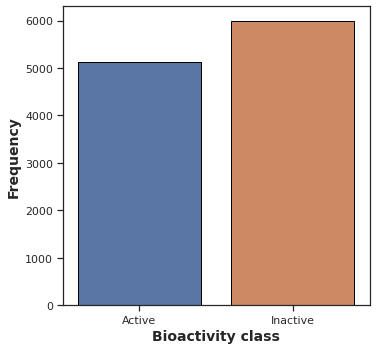

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='PUBCHEM_ACTIVITY_OUTCOME', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class_short.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

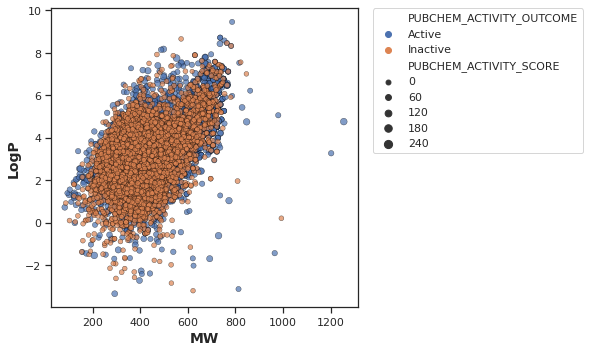

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='PUBCHEM_ACTIVITY_OUTCOME', 
                size='PUBCHEM_ACTIVITY_SCORE', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP_short.pdf')

### **Box plots**

#### **pIC50 value**

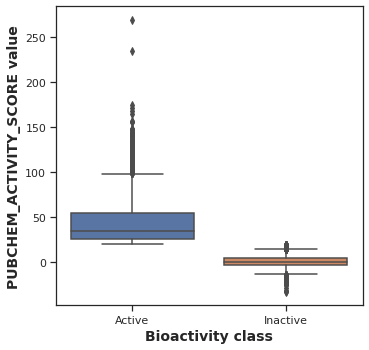

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'PUBCHEM_ACTIVITY_OUTCOME', y = 'PUBCHEM_ACTIVITY_SCORE', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('PUBCHEM_ACTIVITY_SCORE value', fontsize=14, fontweight='bold')

plt.savefig('plot_activty_score_short.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'PUBCHEM_ACTIVITY_OUTCOME']
  df = df_2class[selection]
  active = df[df['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']
  active = active[descriptor]

  selection = [descriptor, 'PUBCHEM_ACTIVITY_OUTCOME']
  df = df_2class[selection]
  inactive = df[df['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor +'_short'+ '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('PUBCHEM_ACTIVITY_SCORE')

,Descriptor,Statistics,p,alpha,Interpretation
0,PUBCHEM_ACTIVITY_SCORE,0.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

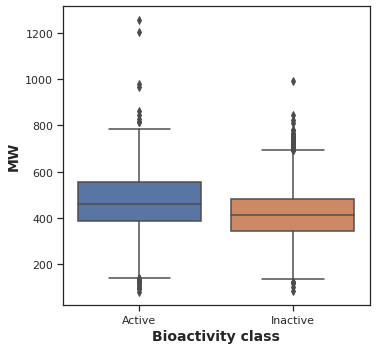

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'PUBCHEM_ACTIVITY_OUTCOME', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW_short.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,11458660.0,2.473219e-120,0.05,Different distribution (reject H0)


#### **LogP**

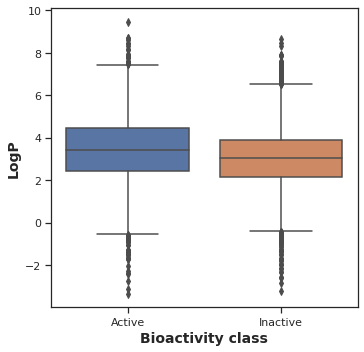

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'PUBCHEM_ACTIVITY_OUTCOME', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP_short.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,12898544.0,1.042740e-49,0.05,Different distribution (reject H0)


#### **NumHDonors**

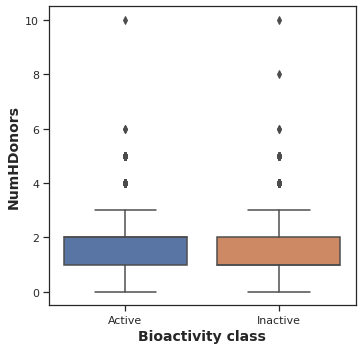

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'PUBCHEM_ACTIVITY_OUTCOME', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors_short.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,13503048.5,3.692189e-32,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

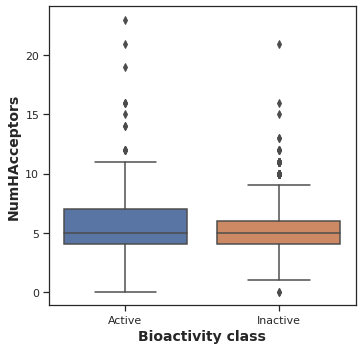

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'PUBCHEM_ACTIVITY_OUTCOME', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors_short.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,14475909.0,1.712196e-08,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_NumHAcceptors_short.pdf (deflated 39%)
  adding: mannwhitneyu_MW_short.csv (deflated 10%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_NumHDonors_short.pdf (deflated 38%)
  adding: mannwhitneyu_PUBCHEM_ACTIVITY_SCORE_short.csv (deflated 8%)
  adding: data_with_lipinski_descriptors_short.csv (deflated 76%)
  adding: data_with_lipinski_descriptors.csv (deflated 76%)
  adding: mannwhitneyu_NumHDonors_short.csv (deflated 11%)
  adding: plot_LogP_short.pdf (deflated 35%)
  adding: mannwhitneyu_LogP_short.csv (deflated 9%)
  adding: plot_bioactivity_class_short.pdf (deflated 38%)
  adding: plot_MW_vs_LogP_short.pdf (deflated 2%)
  adding: plot_MW_short.pdf (deflated 37%)
  adding: plot_activty_score_short.pdf (deflated 38%)
  adding: mannwhitneyu_NumHAcceptors_short.csv (deflated 11%)
  adding: data_with_lipinski_descriptor-2classes_short.csv (deflated 76%)
  adding: smile_activity_data_short.csv (deflated 80%)
  adding: plot_LogP.pdf (deflated 35%)
